<a href="https://colab.research.google.com/github/Ahaannarang/movie-profit-predictor/blob/main/Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [34]:
# STEP 2 Load DATA
from google.colab import files
import pandas as pd

# Change later when moving to github
uploaded = files.upload()

# Load the core metadata file (main dataset)
movies = pd.read_csv("movies_metadata.csv", low_memory=False)

# Load extra files, small ratings gives similar trend as big
keywords = pd.read_csv("keywords.csv")
credits = pd.read_csv("credits.csv")
ratings = pd.read_csv("ratings_small.csv")

# Preview each dataset
print("Movies Metadata:")
display(movies.head(2))

print("\nKeywords:")
display(keywords.head(2))

print("\nCredits:")
display(credits.head(2))

print("\nRatings (small subset):")
display(ratings.head(2))


Movies Metadata:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0



Keywords:


,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."



Credits:


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844



Ratings (small subset):


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


In [54]:
#Clean and attatch keywords
import ast
import numpy as np
import pandas as pd

# 0) Safety: ensure unique column labels
movies   = movies.loc[:, ~movies.columns.duplicated()].copy()
keywords = keywords.loc[:, ~keywords.columns.duplicated()].copy()

# 1) Ensure a single numeric join key on movies
if "id_num" not in movies.columns:
    movies["id_num"] = pd.to_numeric(movies.get("id"), errors="coerce")
if movies.columns.duplicated().any():
    movies = movies.loc[:, ~movies.columns.duplicated()].copy()

# 2) Attach keywords only if we don't already have kw_list
def _parse_keywords(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list):
            return [(d.get("name","") or "").strip().lower() for d in arr if isinstance(d, dict)]
    except Exception:
        pass
    return []

_need_kw = "kw_list" not in movies.columns

if _need_kw:
    # If movies already has a 'keywords' string column, use it; else merge from keywords.csv
    if "keywords" in movies.columns:
        src_col = "keywords"
    elif "keywords" in globals():
        kw = keywords.copy()
        keycol = "id" if "id" in kw.columns else ("tmdbId" if "tmdbId" in kw.columns else None)
        if keycol is None:
            raise KeyError("Could not find a TMDB id column in keywords.csv (expected 'id' or 'tmdbId').")
        kw["id_num"] = pd.to_numeric(kw[keycol], errors="coerce")
        kw = kw[["id_num", "keywords"]].dropna(subset=["id_num"]).drop_duplicates(subset=["id_num"])
        # Merge (one-to-one expected). This does NOT create duplicate labels when columns are unique.
        movies = movies.merge(kw, on="id_num", how="left", validate="one_to_one")
        src_col = "keywords"
    else:
        # No keywords available; create empty lists
        movies["kw_list"] = [[] for _ in range(len(movies))]
        src_col = None

    if src_col is not None:
        movies["kw_list"] = movies[src_col].apply(_parse_keywords)

# 3) Guarantee fields your cluster code needs
if "release_year" not in movies.columns:
    movies["release_year"] = pd.to_datetime(movies.get("release_date"), errors="coerce").dt.year
if "decade" not in movies.columns:
    movies["decade"] = (movies["release_year"] // 10 * 10).astype("Int64")
if "is_profitable" not in movies.columns:
    movies["is_profitable"] = (movies["revenue"] > movies["budget"]).astype(int)

# 4) Build kw_df directly from movies (NO second merge -> no duplicate labels)
_required = ["id_num", "release_year", "is_profitable", "popularity", "kw_list"]
_missing  = [c for c in _required if c not in movies.columns]
if _missing:
    raise KeyError(f"Missing columns for keyword clusters: {_missing}. Re-run Step 3 cells first.")

kw_df = movies[_required].dropna(subset=["release_year"]).copy()




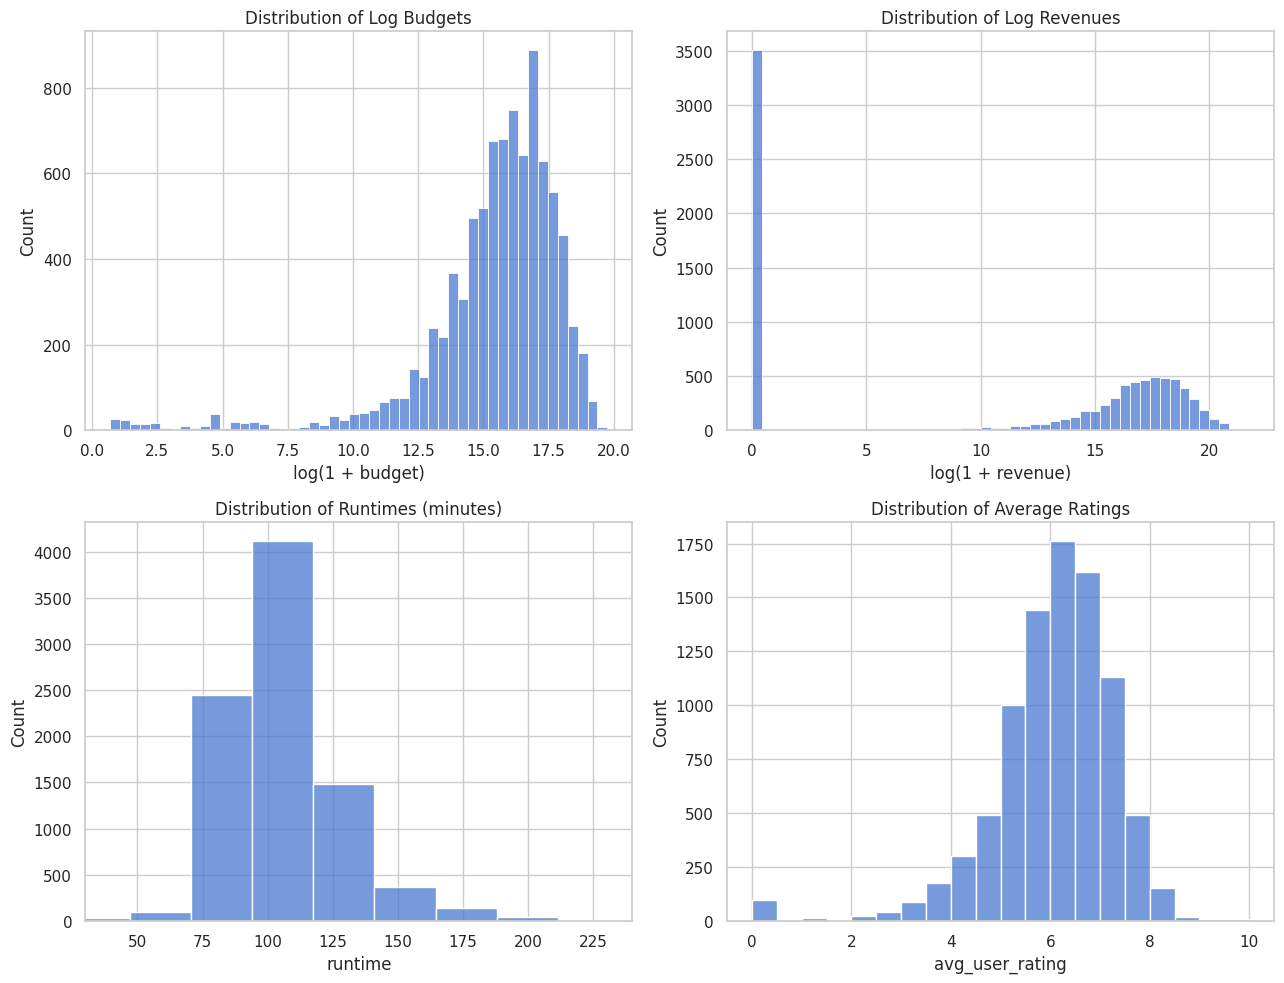

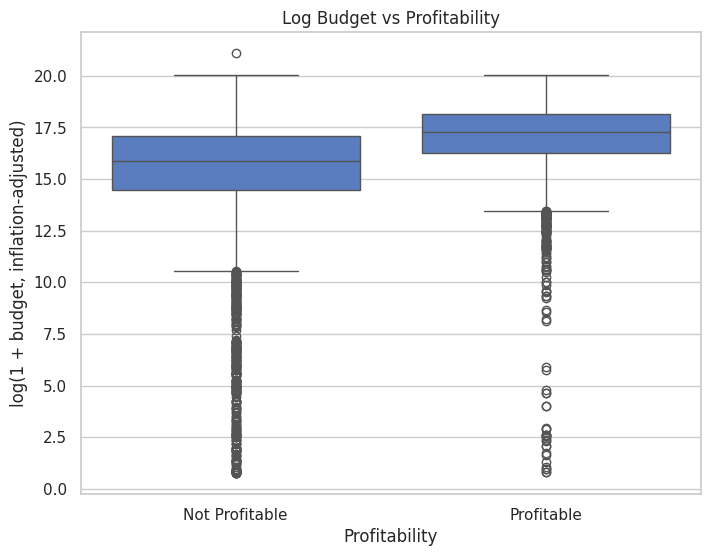

/tmp/ipython-input-3479830549.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="muted")


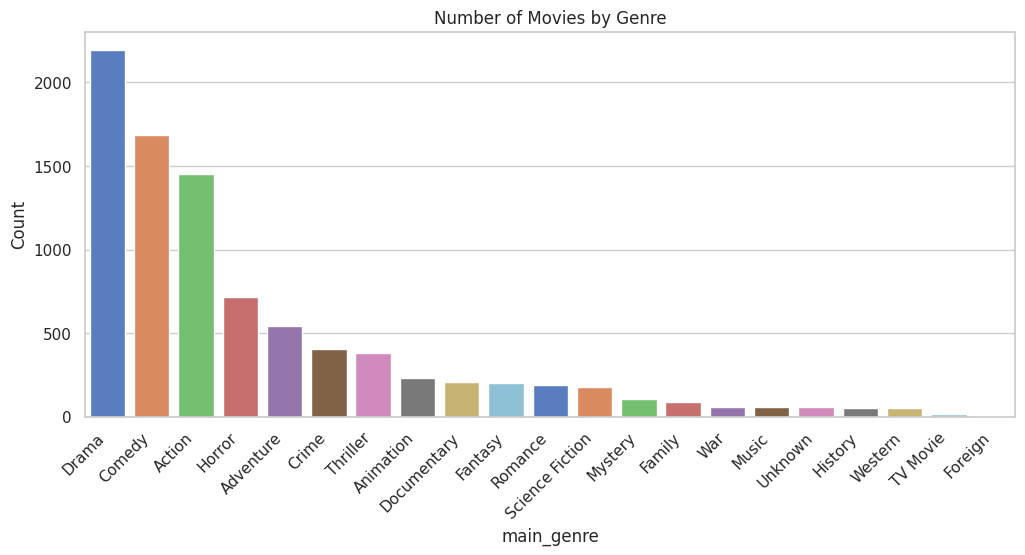


Movies per genre:
 main_genre
Drama          2194
Comedy         1683
Action         1450
Horror          719
Adventure       543
Crime           406
Thriller        381
Animation       233
Documentary     209
Fantasy         204
Name: count, dtype: int64


/tmp/ipython-input-3479830549.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="Blues_d")


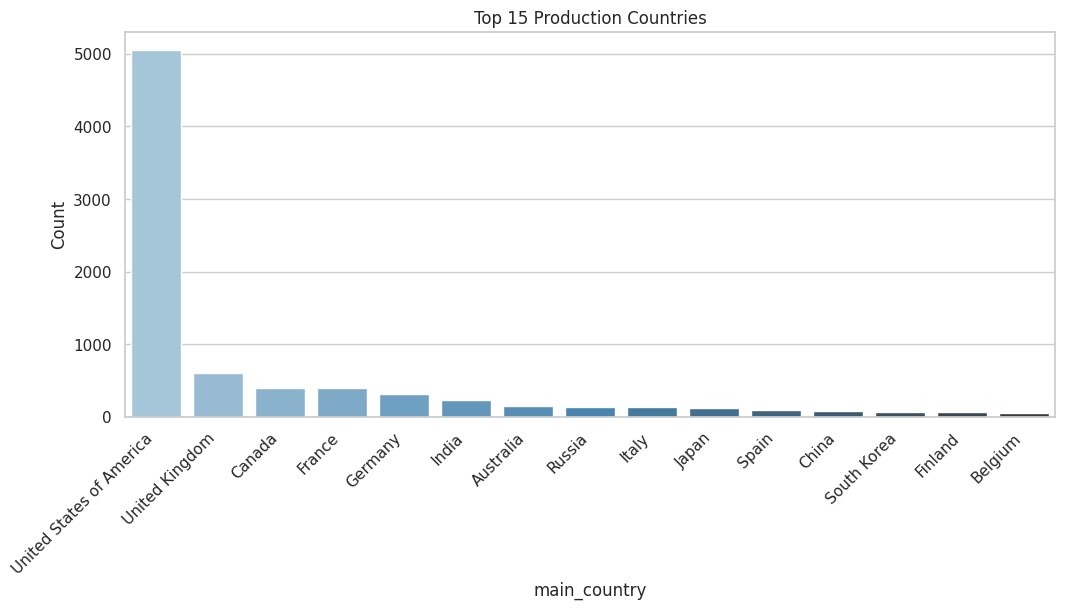


Movies per country (top 15):
 main_country
United States of America    5050
United Kingdom               602
Canada                       393
France                       391
Germany                      314
India                        228
Australia                    147
Russia                       133
Italy                        131
Japan                        118
Spain                         91
China                         81
South Korea                   72
Finland                       72
Belgium                       54
Name: count, dtype: int64


/tmp/ipython-input-3479830549.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_langs.index, y=top_langs.values, palette="Greens_d")


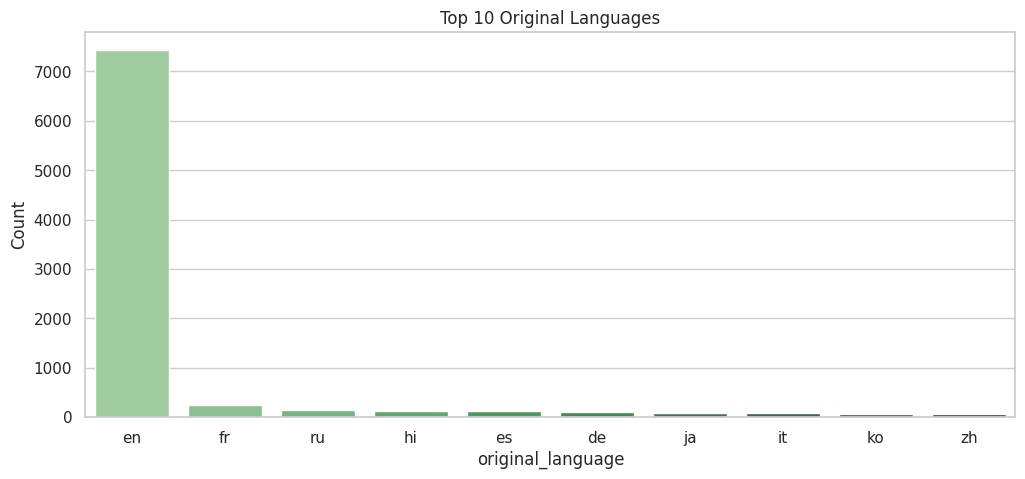


Movies per language (top 10):
 original_language
en    7428
fr     239
ru     139
hi     131
es     113
de      96
ja      83
it      83
ko      67
zh      65
Name: count, dtype: int64


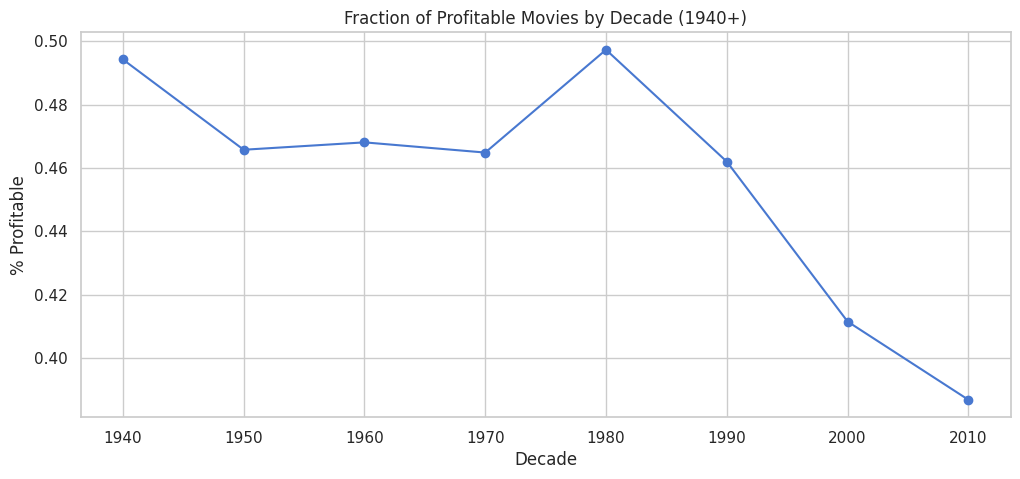

/tmp/ipython-input-3479830549.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=profit_by_genre.index, y=profit_by_genre.values, palette="muted")


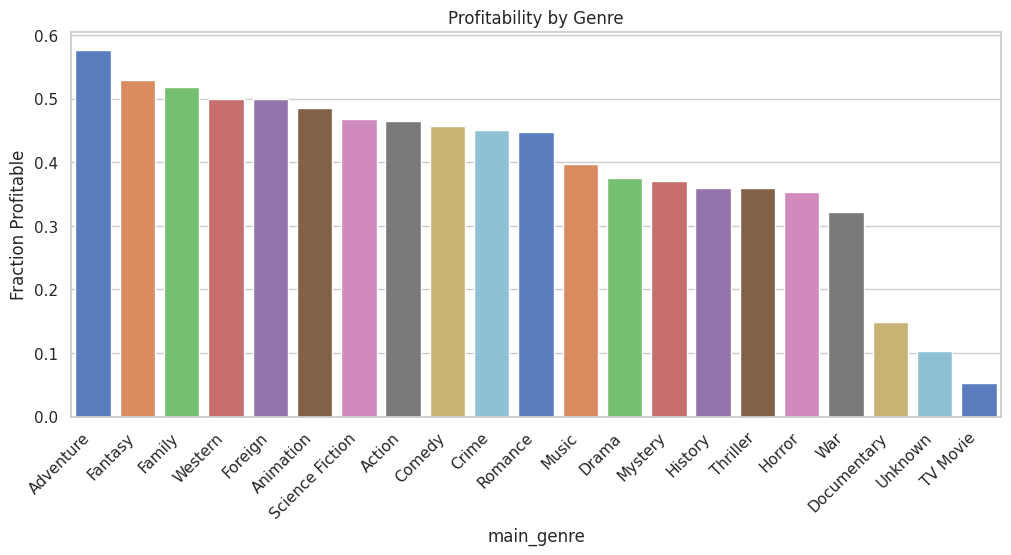

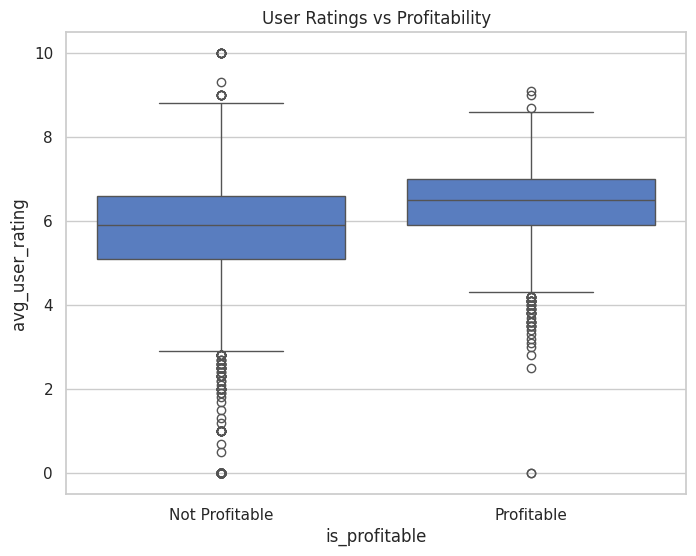

/tmp/ipython-input-3479830549.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="runtime_bucket", y="is_profitable", data=movies, order=labels, palette="muted")


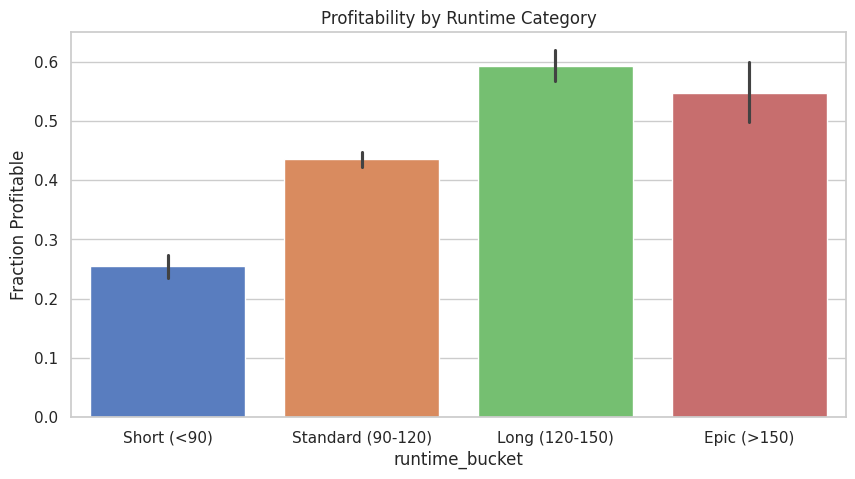


Key EDA takeaways:
* Budgets & revenues are highly skewed → log transforms essential.
* Dataset is dominated by US/English-language films; strong bias.
* Drama/Comedy dominate in counts, but profitability is higher in Action/Sci-Fi.
* Ratings are compressed (~6–7), so limited predictive signal.
* Runtime sweet spot: 90–120 minutes tend to be more profitable.
* Profitability trends shift by decade (post-1980 franchise boom, superhero era).


In [69]:
# STEP 4 — Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")


# 1) Distributions of numeric features
fig, axes = plt.subplots(2,2, figsize=(13,10))

sns.histplot(movies["log_budget"], bins=50, ax=axes[0,0])
axes[0,0].set_title("Distribution of Log Budgets")
axes[0,0].set_xlabel("log(1 + budget)")

sns.histplot(movies["log_revenue"], bins=50, ax=axes[0,1])
axes[0,1].set_title("Distribution of Log Revenues")
axes[0,1].set_xlabel("log(1 + revenue)")

sns.histplot(movies["runtime"], bins=30, ax=axes[1,0])
axes[1,0].set_title("Distribution of Runtimes (minutes)")
axes[1,0].set_xlim(30, 240)   # Trim outliers

sns.histplot(movies["avg_user_rating"], bins=20, ax=axes[1,1])
axes[1,1].set_title("Distribution of Average Ratings")

plt.tight_layout()
plt.show()


#bugdet compared to profitability
plt.figure(figsize=(8,6))
sns.boxplot(x="is_profitable", y="log_budget_adj", data=movies)
plt.title("Log Budget vs Profitability")
plt.xticks([0,1], ["Not Profitable", "Profitable"])
plt.ylabel("log(1 + budget, inflation-adjusted)")
plt.xlabel("Profitability")
plt.show()

# 2) Dataset composition: genres, languages, countries

# Genre distribution
genre_counts = movies["main_genre"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="muted")
plt.title("Number of Movies by Genre")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()
print("\nMovies per genre:\n", genre_counts.head(10))

# Country distribution (main production country)
def get_first_country(cell):
    try:
        lst = eval(cell) if isinstance(cell, str) and cell.startswith("[") else []
        if isinstance(lst, list) and len(lst) > 0 and isinstance(lst[0], dict):
            return lst[0]["name"]
    except:
        return None
    return None

movies["main_country"] = movies["production_countries"].apply(get_first_country)

country_counts = movies["main_country"].value_counts().head(15)
plt.figure(figsize=(12,5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Blues_d")
plt.title("Top 15 Production Countries")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()
print("\nMovies per country (top 15):\n", country_counts)

# Language distribution
top_langs = movies["original_language"].value_counts().head(10)
plt.figure(figsize=(12,5))
sns.barplot(x=top_langs.index, y=top_langs.values, palette="Greens_d")
plt.title("Top 10 Original Languages")
plt.ylabel("Count")
plt.show()
print("\nMovies per language (top 10):\n", top_langs)

# --------------------------------------------------
# 3) Profitability over time (by decade, 1940+)
# --------------------------------------------------
movies["release_year"] = pd.to_datetime(movies["release_date"], errors="coerce").dt.year
movies["decade"] = (movies["release_year"] // 10 * 10).astype("Int64")

profit_by_decade = (
    movies[movies["release_year"] >= 1940]
    .groupby("decade")["is_profitable"]
    .mean()
)

plt.figure(figsize=(12,5))
profit_by_decade.plot(marker="o")
plt.title("Fraction of Profitable Movies by Decade (1940+)")
plt.ylabel("% Profitable")
plt.xlabel("Decade")
plt.show()

# 4) Profitability by genre
profit_by_genre = (
    movies.groupby("main_genre")["is_profitable"].mean().sort_values(ascending=False)
)
plt.figure(figsize=(12,5))
sns.barplot(x=profit_by_genre.index, y=profit_by_genre.values, palette="muted")
plt.title("Profitability by Genre")
plt.ylabel("Fraction Profitable")
plt.xticks(rotation=45, ha="right")
plt.show()

#
# 5) Ratings vs profitability
plt.figure(figsize=(8,6))
sns.boxplot(x="is_profitable", y="avg_user_rating", data=movies)
plt.title("User Ratings vs Profitability")
plt.xticks([0,1], ["Not Profitable", "Profitable"])
plt.show()

# 6) Runtime vs profitability
bins = [0, 90, 120, 150, 1000]
labels = ["Short (<90)", "Standard (90-120)", "Long (120-150)", "Epic (>150)"]
movies["runtime_bucket"] = pd.cut(movies["runtime"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,5))
sns.barplot(x="runtime_bucket", y="is_profitable", data=movies, order=labels, palette="muted")
plt.title("Profitability by Runtime Category")
plt.ylabel("Fraction Profitable")
plt.show()

# Quick points
print("* Budgets & revenues are highly skewed → log transforms essential.")
print("* Dataset is dominated by US/English-language films; strong bias.")
print("* Drama/Comedy dominate in counts, but profitability is higher in Action/Sci-Fi.")
print("* Ratings are compressed (~6–7), so limited predictive signal.")
print("* Runtime sweet spot: 90–120 minutes tend to be more profitable.")





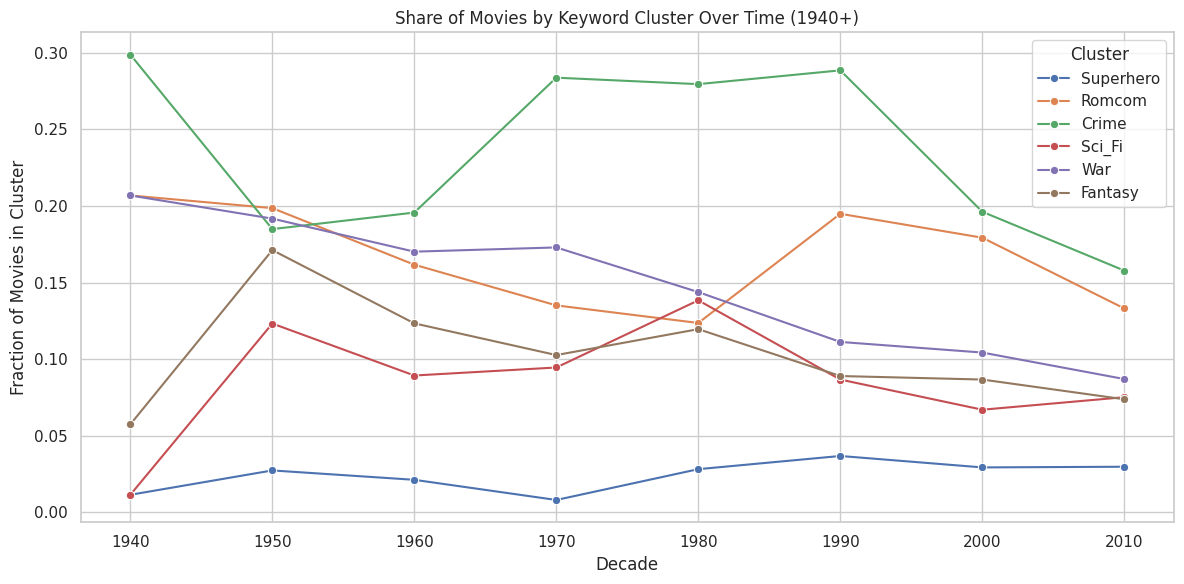

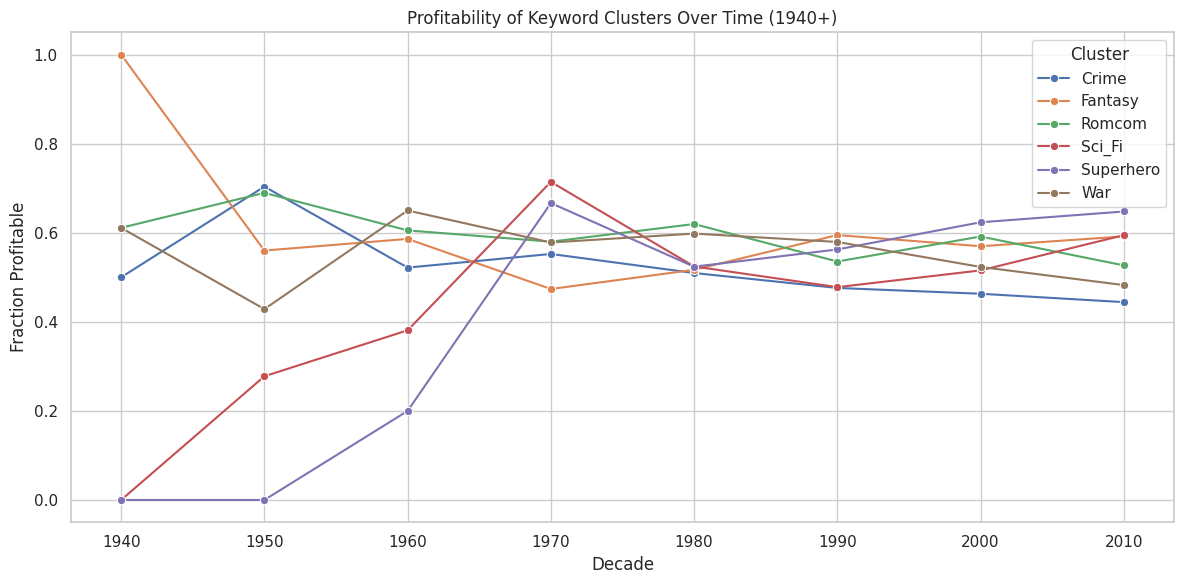

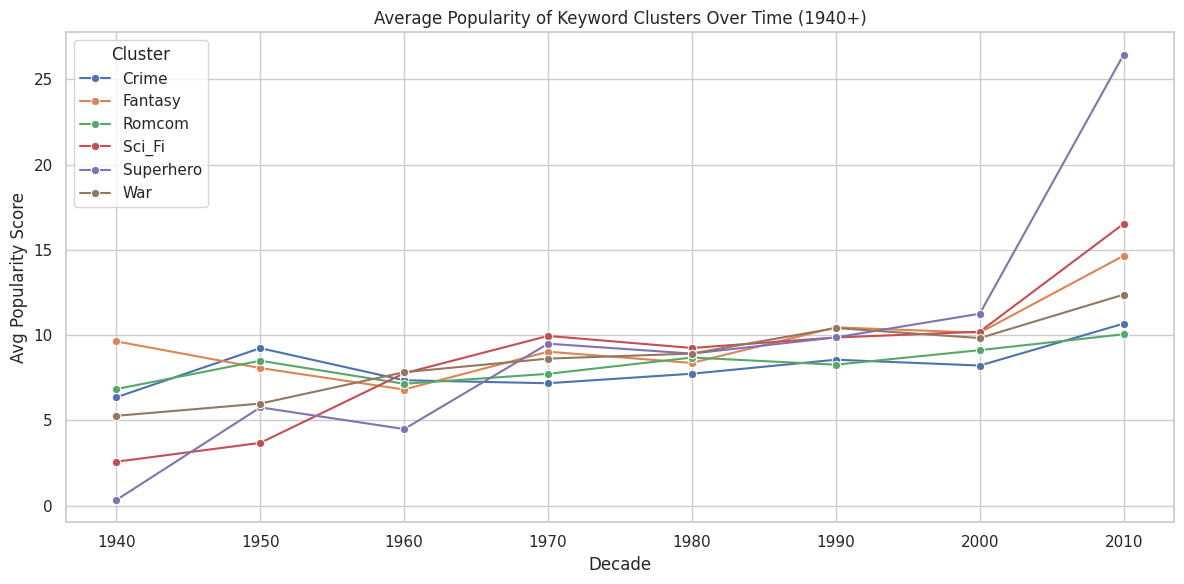

In [65]:
# STEP 4 — Keyword Clusters Over Time (share, profitability, popularity)

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1) make sure labels are unique
movies = movies.loc[:, ~movies.columns.duplicated()].copy()

# 2) required columns from Step 3
if "id_num" not in movies.columns:
    movies["id_num"] = pd.to_numeric(movies.get("id"), errors="coerce")
if "release_year" not in movies.columns:
    movies["release_year"] = pd.to_datetime(movies.get("release_date"), errors="coerce").dt.year
if "is_profitable" not in movies.columns:
    movies["is_profitable"] = (movies["revenue"] > movies["budget"]).astype(int)
# popularity is in metadata, if missing, default to NaN so means still work
if "popularity" not in movies.columns:
    movies["popularity"] = np.nan

kw_df = movies[["id_num", "release_year", "is_profitable", "popularity"]].copy()

# 3) ensure kw_list exists, fallback: parse a raw 'keywords' string if available
def _parse_kw(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list):
            return [ (d.get("name","") or "").strip().lower() for d in arr if isinstance(d, dict) ]
    except Exception:
        pass
    return []

if "kw_list" in movies.columns:
    kw_df["kw_list"] = movies["kw_list"]
elif "keywords" in movies.columns:
    kw_df["kw_list"] = movies["keywords"].apply(_parse_kw)
else:
    kw_df["kw_list"] = [[] for _ in range(len(kw_df))]

# Defining keywords for clusters
keyword_clusters = {
    "superhero": ["superhero","comic book","marvel","dc comics","avenger","justice league","x-men",
                  "batman","superman","spider-man","iron man","captain america","thor","hulk",
                  "black panther","wonder woman","flash","aquaman","deadpool"],
    "romcom":    ["romantic comedy","romance","love","relationship","wedding","dating","bride",
                  "marriage","valentine","kiss","affair","honeymoon","breakup","couple","first love"],
    "crime":     ["crime","criminal","gangster","mafia","heist","robbery","detective","police",
                  "cop","lawyer","noir","serial killer","murder","drug","cartel","prison",
                  "mob","investigation","thriller"],
    "sci_fi":    ["sci-fi","science fiction","space","spaceship","future","futuristic","alien",
                  "extraterrestrial","robot","cyborg","android","time travel","parallel universe",
                  "artificial intelligence","post-apocalyptic","dystopia","nuclear","genetic",
                  "experiment","outer space","galaxy","ufo"],
    "war":       ["war","world war","soldier","battle","army","military","navy","air force",
                  "vietnam","korea","iraq","afghanistan","civil war","ww1","ww2","invasion",
                  "resistance","combat","weapon","nazi"],
    "fantasy":   ["fantasy","magic","magical","dragon","wizard","witch","sorcerer","sorcery",
                  "spell","potion","mythology","myth","legend","sword","elf","orc","troll",
                  "giant","fairy","castle","kingdom","middle earth","chronicles","epic",
                  "creature","beast","dark lord"]
}

def has_any_cluster_word(kws, cluster_words):
    # substring match: 'time travel' in kw; lowercased already
    return any(any(w in kw for w in cluster_words) for kw in kws)

# flags
for cluster, words in keyword_clusters.items():
    kw_df[f"is_{cluster}"] = kw_df["kw_list"].apply(lambda kws: has_any_cluster_word(kws, words)).astype("uint8")

# ---------- Decade filtering (1940+) ----------
kw_df = kw_df.dropna(subset=["release_year"]).copy()
kw_df = kw_df[kw_df["release_year"] >= 1940]
kw_df["decade"] = (kw_df["release_year"] // 10 * 10).astype("Int64")

# ---------- Share of movies in each cluster ----------
cluster_cols = [c for c in kw_df.columns if c.startswith("is_") and c != "is_profitable"]
share_by_decade = kw_df.groupby("decade", dropna=True)[cluster_cols].mean(numeric_only=True).reset_index()

# ---------- Profitability of clusters by decade ----------
profit_curves = []
for c in cluster_cols:
    sub = kw_df[kw_df[c] == 1]
    if not sub.empty:
        tmp = sub.groupby("decade", dropna=True)["is_profitable"].mean().reset_index()
        tmp["cluster"] = c.replace("is_", "")
        profit_curves.append(tmp)
profit_by_decade = pd.concat(profit_curves, ignore_index=True) if profit_curves else pd.DataFrame()

# ---------- Popularity of clusters by decade ----------
popularity_curves = []
for c in cluster_cols:
    sub = kw_df[kw_df[c] == 1]
    if not sub.empty:
        tmp = sub.groupby("decade", dropna=True)["popularity"].mean().reset_index()
        tmp["cluster"] = c.replace("is_", "")
        popularity_curves.append(tmp)
popularity_by_decade = pd.concat(popularity_curves, ignore_index=True) if popularity_curves else pd.DataFrame()

# ---------------- Plots ----------------
# 1) Fraction of movies per cluster by decade
plt.figure(figsize=(12,6))
for c in cluster_cols:
    sns.lineplot(x="decade", y=c, data=share_by_decade, marker="o", label=c.replace("is_","").title())
plt.title("Share of Movies by Keyword Cluster Over Time (1940+)")
plt.ylabel("Fraction of Movies in Cluster")
plt.xlabel("Decade")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# 2) Profitability of clusters by decade
if not profit_by_decade.empty:
    plt.figure(figsize=(12,6))
    for name, grp in profit_by_decade.groupby("cluster"):
        sns.lineplot(x="decade", y="is_profitable", data=grp, marker="o", label=name.title())
    plt.title("Profitability of Keyword Clusters Over Time (1940+)")
    plt.ylabel("Fraction Profitable")
    plt.xlabel("Decade")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

# 3) Popularity of clusters by decade
if not popularity_by_decade.empty:
    plt.figure(figsize=(12,6))
    for name, grp in popularity_by_decade.groupby("cluster"):
        sns.lineplot(x="decade", y="popularity", data=grp, marker="o", label=name.title())
    plt.title("Average Popularity of Keyword Clusters Over Time (1940+)")
    plt.ylabel("Avg Popularity Score")
    plt.xlabel("Decade")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()



In [61]:
# STEP 5 — Feature engineering
import numpy as np
import pandas as pd
import ast

# ---------- 5A. ADJUST BUDGET/REVENUE FOR INFLATION ----------
BASE_YEAR = 2020
ANNUAL_RATE = 0.03

# Ensure release_year exists
if "release_year" not in movies.columns:
    movies["release_year"] = pd.to_datetime(movies.get("release_date"), errors="coerce").dt.year

yr = movies["release_year"].astype("Float64")
factor = np.power(1.0 + ANNUAL_RATE, BASE_YEAR - yr)
factor = factor.fillna(1.0)

movies["budget_adj"]  = movies["budget"]  * factor
movies["revenue_adj"] = movies["revenue"] * factor

# Logs after adjustment
movies["log_budget_adj"]  = np.log1p(movies["budget_adj"])
movies["log_revenue_adj"] = np.log1p(movies["revenue_adj"])

# Main genre
def _parse_first_genre(cell):
    try:
        arr = ast.literal_eval(cell)
        return arr[0]["name"] if isinstance(arr, list) and arr else "Unknown"
    except Exception:
        return "Unknown"

if "main_genre" not in movies.columns:
    if "genres" in movies.columns:
        movies["main_genre"] = movies["genres"].apply(_parse_first_genre)
    else:
        movies["main_genre"] = "Unknown"

# Keyword cluster flags
def _parse_keywords(cell):
    try:
        arr = ast.literal_eval(cell)
        if isinstance(arr, list):
            return [(d.get("name","") or "").strip().lower() for d in arr if isinstance(d, dict)]
    except Exception:
        pass
    return []

if "kw_list" not in movies.columns:
    if "keywords" in movies.columns:
        movies["kw_list"] = movies["keywords"].apply(_parse_keywords)
    else:
        movies["kw_list"] = [[] for _ in range(len(movies))]

keyword_clusters = {
    "superhero": ["superhero","comic book","marvel","dc comics","avenger","justice league","x-men",
                  "batman","superman","spider-man","iron man","captain america","thor","hulk",
                  "black panther","wonder woman","flash","aquaman","deadpool"],
    "romcom":    ["romantic comedy","romance","love","relationship","wedding","dating","bride",
                  "marriage","valentine","kiss","affair","honeymoon","breakup","couple","first love"],
    "crime":     ["crime","criminal","gangster","mafia","heist","robbery","detective","police",
                  "cop","lawyer","noir","serial killer","murder","drug","cartel","prison",
                  "mob","investigation","thriller"],
    "sci_fi":    ["sci-fi","science fiction","space","spaceship","future","futuristic","alien",
                  "extraterrestrial","robot","cyborg","android","time travel","parallel universe",
                  "artificial intelligence","post-apocalyptic","dystopia","nuclear","genetic",
                  "experiment","outer space","galaxy","ufo"],
    "war":       ["war","world war","soldier","battle","army","military","navy","air force",
                  "vietnam","korea","iraq","afghanistan","civil war","ww1","ww2","invasion",
                  "resistance","combat","weapon","nazi"],
    "fantasy":   ["fantasy","magic","magical","dragon","wizard","witch","sorcerer","sorcery",
                  "spell","potion","mythology","myth","legend","sword","elf","orc","troll",
                  "giant","fairy","castle","kingdom","middle earth","chronicles","epic",
                  "creature","beast","dark lord"]
}

def _has_any_cluster_word(kws, words):
    return any(any(w in kw for w in words) for kw in kws)

for cluster, words in keyword_clusters.items():
    movies[f"is_{cluster}"] = movies["kw_list"].apply(
        lambda kws: _has_any_cluster_word(kws, words)
    ).astype(np.uint8)

# added runtime flags to try see if there is a sweet spot or range
movies["is_short"]  = (movies["runtime"] < 80).astype(np.uint8)
movies["is_medium"] = ((movies["runtime"] >= 80) & (movies["runtime"] <= 140)).astype(np.uint8)
movies["is_long"]   = (movies["runtime"] > 140).astype(np.uint8)

#features
base_features = ["log_budget_adj", "runtime", "vote_average", "vote_count", "popularity"]
base_features = [c for c in base_features if c in movies.columns]

cluster_flags = [f"is_{c}" for c in keyword_clusters.keys() if f"is_{c}" in movies.columns]
runtime_flags = ["is_short","is_medium","is_long"]

features = base_features + cluster_flags + runtime_flags + ["main_genre"]

X = movies[features]
y = movies["is_profitable"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Feature matrix shape:", X.shape)
print("Example columns:", X.columns[:15].tolist())



Feature matrix shape: (8880, 15)
Example columns: ['log_budget_adj', 'runtime', 'vote_average', 'vote_count', 'popularity', 'is_superhero', 'is_romcom', 'is_crime', 'is_sci_fi', 'is_war', 'is_fantasy', 'is_short', 'is_medium', 'is_long', 'main_genre']


In [64]:
# Numeric features → will be standardized (mean=0, std=1).
numeric_features = ["log_budget_adj", "runtime", "vote_average", "vote_count", "popularity"]

# Categorical feature → main_genre is still a string ("Action", "Comedy", etc.),
# so we will one-hot encode it (turn into dummy columns).
categorical_features = ["main_genre"]

# Keyword cluster flags (e.g. is_superhero, is_romcom, ...) and runtime flags, alr binary
kw_flags = [c for c in movies.columns if c.startswith("is_") and c != "is_profitable"]
runtime_flags = ["is_short", "is_medium", "is_long"]


# Scale numeric columns → prevents large numbers (like vote_count) from dominating
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# One-hot encode genres → robust to new/unknown categories
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# ColumnTransformer → combines different preprocessing steps
# (scale numbers, encode genres, pass through flags).
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features), #numerical values
        ("cat", categorical_transformer, categorical_features), #categorical values
        ("flags", "passthrough", kw_flags + runtime_flags), #flags
    ],
    remainder="drop"  # ignore anything not listed
)


# Log regress.
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Train model
log_reg.fit(X_train, y_train)

# Evaluate on the test set
print("Logistic Regression Results")
print(classification_report(y_test, log_reg.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))
#  Precision of the movies predicted profitable, how many actually were
# Recall, of the profitable movies, how many did we catch F1: prec+reclass
# ROC-AUC: how well the model separates profitable vs not across thresholds

# Random Forest is more flexible than logistic regression builds many decision trees and averages them.
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train
rf.fit(X_train, y_train)

# Evaluate performance
print("\nRandom Forest Results")
print(classification_report(y_test, rf.predict(X_test)))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1012
           1       0.81      0.64      0.71       764

    accuracy                           0.78      1776
   macro avg       0.79      0.76      0.77      1776
weighted avg       0.78      0.78      0.77      1776

ROC-AUC: 0.8511694741634419

Random Forest Results
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1012
           1       0.78      0.69      0.73       764

    accuracy                           0.78      1776
   macro avg       0.78      0.77      0.77      1776
weighted avg       0.78      0.78      0.78      1776

ROC-AUC: 0.8554841897233201


In [79]:
# Studio 300 mil tests - testing movies, assuming 2010 release

# Use dataset averages for unknown audience-side features
avg_vote_count = movies["vote_count"].mean()
avg_vote_average = movies["vote_average"].mean()
avg_popularity = movies["popularity"].mean()

portfolio = pd.DataFrame([
    # 2 high-budget blockbusters
    {"title": "Action Superhero Movie", "release_year": 2010, "budget": 200_000_000, "runtime": 120,
     "main_genre": "Action", "is_superhero": 1, "is_sci_fi": 1,
     "is_romcom": 0, "is_crime": 0, "is_war": 0, "is_fantasy": 0,
     "is_short": 0, "is_medium": 1, "is_long": 0,
     "vote_count": avg_vote_count, "vote_average": avg_vote_average, "popularity": avg_popularity},

    # 2 mid-budget romcoms
    {"title": "Romantic Comedy 1", "release_year": 2010, "budget": 50_000_000, "runtime": 110,
     "main_genre": "Romance", "is_romcom": 1, "is_crime": 0, "is_superhero": 0,
     "is_sci_fi": 0, "is_war": 0, "is_fantasy": 0,
     "is_short": 0, "is_medium": 1, "is_long": 0,
     "vote_count": avg_vote_count, "vote_average": avg_vote_average, "popularity": avg_popularity},

    {"title": "Romantic Comedy 2", "release_year": 2010, "budget": 50_000_000, "runtime": 115,
     "main_genre": "Romance", "is_romcom": 1, "is_crime": 0, "is_superhero": 0,
     "is_sci_fi": 0, "is_war": 0, "is_fantasy": 0,
     "is_short": 0, "is_medium": 1, "is_long": 0,
     "vote_count": avg_vote_count, "vote_average": avg_vote_average, "popularity": avg_popularity},
])

# Adjust for inflation + log
factor = np.power(1.0 + 0.03, 2020 - portfolio["release_year"])
portfolio["budget_adj"] = portfolio["budget"] * factor
portfolio["log_budget_adj"] = np.log1p(portfolio["budget_adj"])

# Predict with both models
print("Predictions for $300M Portfolio:")
for model_name, model in [("LogReg", log_reg), ("RandomForest", rf)]:
    probs = model.predict_proba(portfolio)[:, 1]
    preds = model.predict(portfolio)
    portfolio[f"{model_name}_Prob"] = probs
    portfolio[f"{model_name}_Pred"] = preds

print(portfolio[["title", "budget", "main_genre", "LogReg_Prob", "RandomForest_Prob"]])


Predictions for $300M Portfolio:
                    title     budget main_genre  LogReg_Prob  \
0  Action Superhero Movie  200000000     Action     0.508969   
1       Romantic Comedy 1   50000000    Romance     0.736826   
2       Romantic Comedy 2   50000000    Romance     0.737929   

   RandomForest_Prob  
0               0.70  
1               0.90  
2               0.86  
